Dataset shape: (297, 8)
Features: ['ca', 'thalach', 'chol', 'age', 'thal', 'trestbps', 'oldpeak', 'cp']
Target value counts:
target
0    160
1    137
Name: count, dtype: int64
Number of unique target values: 2

Training set: (237, 8)
Test set: (60, 8)

Model Training and Evaluation:

Logistic Regression:
  Accuracy:  0.850
  Precision: 0.880
  Recall:    0.786
  F1-Score:  0.830
  AUC:       0.948

Decision Tree:
  Accuracy:  0.733
  Precision: 0.731
  Recall:    0.679
  F1-Score:  0.704
  AUC:       0.730

Random Forest:
  Accuracy:  0.817
  Precision: 0.870
  Recall:    0.714
  F1-Score:  0.784
  AUC:       0.936

SVM:
  Accuracy:  0.833
  Precision: 0.875
  Recall:    0.750
  F1-Score:  0.808
  AUC:       0.944

Results Summary:
                     Accuracy  Precision  Recall  F1-Score    AUC
Logistic Regression     0.850      0.880   0.786     0.830  0.948
Decision Tree           0.733      0.731   0.679     0.704  0.730
Random Forest           0.817      0.870   0.714     0.784  

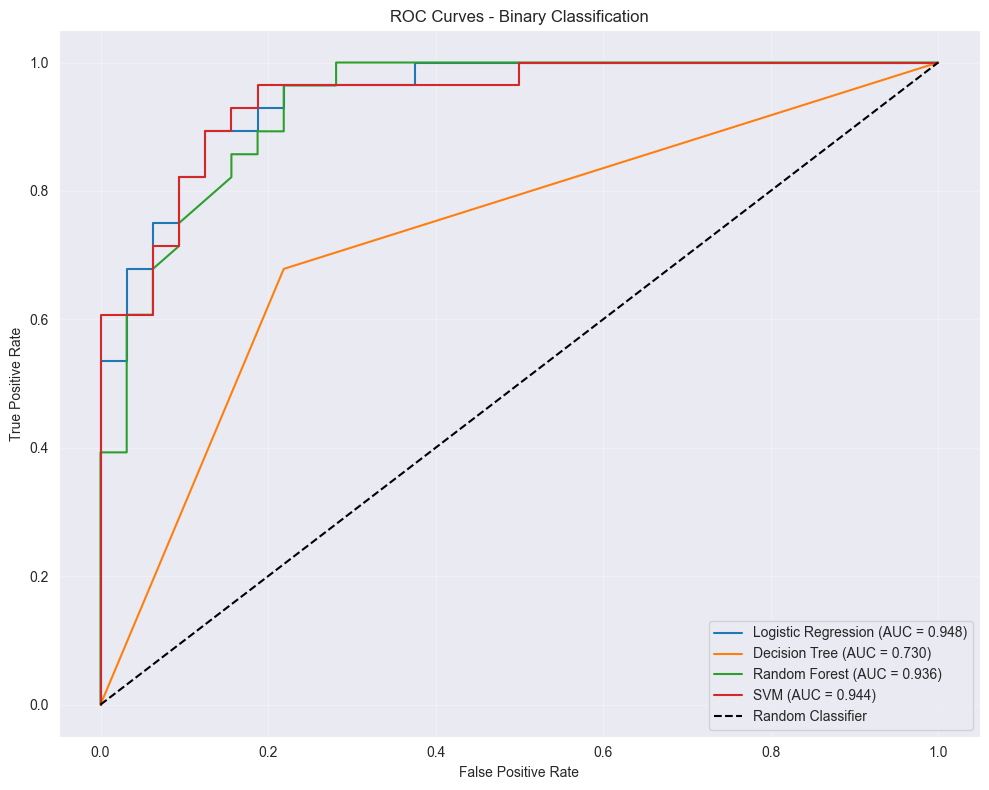


Best Model: Logistic Regression
F1-Score: 0.830

Best model saved to ../models/best_model.pkl
Model results saved to ../models/model_results.csv


In [1]:
# Heart Disease UCI Dataset - Supervised Learning
# Notebook 04: Supervised Learning Models & Classification

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import joblib
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

# Load selected features data
df = pd.read_csv('../data/processed/selected_features.csv')

# Separate features and target
X = df.drop('target', axis=1)  # All features except target
y = df['target']  # Target only

print("Dataset shape:", X.shape)
print("Features:", X.columns.tolist())
print("Target value counts:")
print(y.value_counts().sort_index())
print(f"Number of unique target values: {y.nunique()}")

# Split data into train and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale features for logistic regression and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models with improved parameters
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='liblinear'
    ),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),  #  uses 100 decision trees
    'SVM': SVC(probability=True, random_state=42, kernel='rbf')
}

# Train and evaluate models
results = {}
model_objects = {}

print("\nModel Training and Evaluation:")
print("=" * 50)

for name, model in models.items():
    # Use scaled data for Logistic Regression and SVM
    if name in ['Logistic Regression', 'SVM']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    #(Tree-based models (Decision Tree, Random Forest) don't need scaling)
    else:
        X_train_use = X_train
        X_test_use = X_test

    # Train model
    model.fit(X_train_use, y_train)

    # Make predictions
    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)[:, 1]  # Positive class probability

    # Calculate binary classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    }

    model_objects[name] = {
        'model': model,
        'scaler': scaler if name in ['Logistic Regression', 'SVM'] else None
    }

    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-Score:  {f1:.3f}")
    print(f"  AUC:       {auc:.3f}")

# Create results DataFrame
results_df = pd.DataFrame(results).T
print("\nResults Summary:")
print(results_df.round(3))

# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, model_info in model_objects.items():
    model = model_info['model']
    scaler = model_info['scaler']

    # Use appropriate data
    X_test_use = X_test_scaled if scaler else X_test
    y_pred_proba = model.predict_proba(X_test_use)[:, 1]  # Positive class probability

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  #False Positive Rate (x-axis), True Positive Rate (y-axis)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Binary Classification')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find best model based on highest F1-score
best_model_name = results_df['F1-Score'].idxmax()
best_model_info = model_objects[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.3f}")

# Save the best model and its scaler (if applicable)
best_model_data = {
    'model': best_model_info['model'],
    'scaler': best_model_info['scaler'],
    'feature_names': X.columns.tolist()
}

joblib.dump(best_model_data, '../models/best_model.pkl')
print(f"\nBest model saved to ../models/best_model.pkl")

# Save all model results
results_df.to_csv('../models/model_results.csv')
print("Model results saved to ../models/model_results.csv")

# Print feature importance for tree-based models (Only tree-based models provide feature importance) (Shows which features contribute most to predictions)
if best_model_name in ['Decision Tree', 'Random Forest']:
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model_info['model'].feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nFeature Importance ({best_model_name}):")
    print(feature_importance.head(10))